In [30]:
%pip install pandas numpy matplotlib seaborn scipy statsmodels

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 34.2 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

In [46]:
# 1. Ler o arquivo
data = pd.read_csv("GSE100522.txt", sep="\t")

# 2. Remover genes com gene_id ausente
data = data.dropna(subset=['gene_id'])

# 3. Converter gene_id para string e usar como índice
data['gene_id'] = data['gene_id'].astype(str)
data.set_index('gene_id', inplace=True)

In [48]:
# Seleciona colunas de contagem + gene_short_name
count_cols = [col for col in data.columns if col.endswith("_count")]
counts = data[["gene_short_name"] + count_cols].copy()

In [49]:
# 3. Filtrar genes com baixa expressão (soma total < 10)
counts_filtered = counts[count_cols].loc[counts[count_cols].sum(axis=1) >= 10]
print(f"Genes após filtro: {counts_filtered.shape[0]}")

Genes após filtro: 17566


In [50]:
# 4. Normalização log2(count + 1)
log_counts = np.log2(counts_filtered + 1)
print(log_counts.index[:5])

Index(['71661.0', '58520.0', '66050.0', '66838.0', '66839.0'], dtype='object', name='gene_id')


In [51]:
# 5. Definir grupos
GS_group = ['GS-1_count', 'GS-2_count', 'GS-3_count']
CK_group = ['CK-1_count', 'CK-2_count', 'CK-3_count']
print(f"GS group: {GS_group}")
print(f"CK group: {CK_group}")

GS group: ['GS-1_count', 'GS-2_count', 'GS-3_count']
CK group: ['CK-1_count', 'CK-2_count', 'CK-3_count']


In [52]:
# 6. Teste t de Student gene a gene
p_values = []
log2_fc = []
valid_genes = []

for gene in log_counts.index:
    gs_vals = log_counts.loc[gene, GS_group]
    ck_vals = log_counts.loc[gene, CK_group]

    # Garante que são Series
    gs_vals = pd.Series(gs_vals)
    ck_vals = pd.Series(ck_vals)

    # Verifica NaNs
    if gs_vals.isnull().any() or ck_vals.isnull().any():
        continue

    # Verifica se todos os valores são iguais
    if gs_vals.nunique() <= 1 and ck_vals.nunique() <= 1:
        continue

    # Teste t com conversão para arrays
    t_stat, p = ttest_ind(gs_vals.values, ck_vals.values, equal_var=False)
    p_values.append(p)
    log2_fc.append(gs_vals.mean() - ck_vals.mean())
    valid_genes.append(gene)

In [53]:
# Garantir que estamos trabalhando apenas com genes válidos
results = pd.DataFrame({
    "gene_short_name": counts.loc[valid_genes, "gene_short_name"],
    "log2_FC": log2_fc,
    "p_value": p_values
}, index=valid_genes)

# Corrigir p-valor
rejected, pvals_corrected, _, _ = multipletests(results["p_value"], method='fdr_bh')
results["FDR"] = pvals_corrected

In [54]:
# 7. Corrigir p-valor (FDR)
rejected, pvals_corrected, _, _ = multipletests(p_values, method='fdr_bh')

In [55]:
# 8. Criar tabela de resultados
results = pd.DataFrame({
    "gene_short_name": counts["gene_short_name"],
    "log2_FC": log2_fc,
    "p_value": p_values,
    "FDR": pvals_corrected
}, index=log_counts.index)

In [56]:
# 9. Exportar genes significativos
significant_genes = results[results["FDR"] < 0.05]
print(f"Número de genes diferencialmente expressos (FDR < 0.05): {significant_genes.shape[0]}")
significant_genes.to_csv("genes_diferenciais.csv")

Número de genes diferencialmente expressos (FDR < 0.05): 0


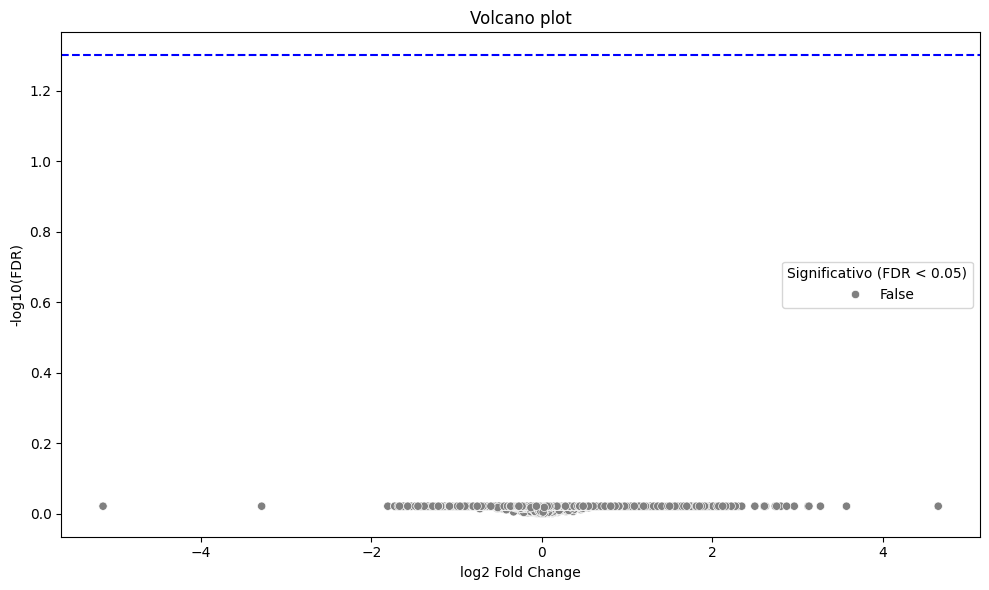

In [57]:
# 10. Plot Volcano
plt.figure(figsize=(10,6))
sns.scatterplot(data=results, x="log2_FC", y=-np.log10(results["FDR"]), hue=(results["FDR"] < 0.05), palette={True: 'red', False: 'gray'})
plt.axhline(-np.log10(0.05), color='blue', linestyle='--')
plt.title("Volcano plot")
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10(FDR)")
plt.legend(title="Significativo (FDR < 0.05)")
plt.tight_layout()
plt.savefig("volcano_plot.png")
plt.show()